In [135]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import glob
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

In [136]:
'''
        Each file contains nine columns and a different number of rows depending on the test length.
        
        1st column is the acceleration data in the X axis measured by the sensor ADXL345.
        2nd column is the acceleration data in the Y axis measured by the sensor ADXL345.
        3rd column is the acceleration data in the Z axis measured by the sensor ADXL345.

        4th column is the rotation data in the X axis measured by the sensor ITG3200.
        5th column is the rotation data in the Y axis measured by the sensor ITG3200.
        6th column is the rotation data in the Z axis measured by the sensor ITG3200.

        7th column is the acceleration data in the X axis measured by the sensor MMA8451Q.
        8th column is the acceleration data in the Y axis measured by the sensor MMA8451Q.
        9th column is the acceleration data in the Z axis measured by the sensor MMA8451Q.
        
        Data are in bits with the following characteristics:

        ADXL345:
        Resolution: 13 bits
        Range: +-16g

        ITG3200
        Resolution: 16 bits
        Range: +-2000°/s

        MMA8451Q:
        Resolution: 14 bits
        Range: +-8g
'''

'\n        Each file contains nine columns and a different number of rows depending on the test length.\n        \n        1st column is the acceleration data in the X axis measured by the sensor ADXL345.\n        2nd column is the acceleration data in the Y axis measured by the sensor ADXL345.\n        3rd column is the acceleration data in the Z axis measured by the sensor ADXL345.\n\n        4th column is the rotation data in the X axis measured by the sensor ITG3200.\n        5th column is the rotation data in the Y axis measured by the sensor ITG3200.\n        6th column is the rotation data in the Z axis measured by the sensor ITG3200.\n\n        7th column is the acceleration data in the X axis measured by the sensor MMA8451Q.\n        8th column is the acceleration data in the Y axis measured by the sensor MMA8451Q.\n        9th column is the acceleration data in the Z axis measured by the sensor MMA8451Q.\n        \n        Data are in bits with the following characteristics:\

In [137]:
WINDOW_LENGTH = 256
STRIDE = 128
TRAIN_DATA_USE_RATE = 0.5
datapath = "./data/SisFall_dataset/"

In [138]:
adl_activities = [f'D{str(i).zfill(2)}' for i in range(1, 20)]  # D01-D19
fall_activities = [f'F{str(i).zfill(2)}' for i in range(1, 16)]  # F01-F15

label2id = {act: 0 for act in adl_activities}
label2id.update({act: 1 for act in fall_activities})

adult_subjects = [f'SA{str(i).zfill(2)}' for i in range(1, 24)]  # SA01-SA23
elderly_subjects = [f'SE{str(i).zfill(2)}' for i in range(1, 16)]  # SE01-SE15

train_sa = adult_subjects[:16]    # 16 subjects
val_sa = adult_subjects[16:19]    # 3 subjects
test_sa = adult_subjects[19:]     # 4 subjects

train_se = elderly_subjects[:10]  # 10 subjects
val_se = elderly_subjects[10:12]  # 2 subjects
test_se = elderly_subjects[12:]   # 3 subjects

train_split = train_sa + train_se
val_split = val_sa + val_se
test_split = test_sa + test_se

In [139]:
np.random.seed(42) 
train_split = np.random.choice(train_split, 
                                       size=int(len(train_split)*TRAIN_DATA_USE_RATE), 
                                       replace=False)

print (train_split)

['SA09' 'SE01' 'SA01' 'SE09' 'SA12' 'SA10' 'SA14' 'SA02' 'SE08' 'SA06'
 'SA03' 'SA13' 'SA16']


In [140]:
def read_sensor_file(filepath) :
   with open(filepath, 'r') as file:
       content = file.read()

   content = content.replace(' ', '')  # delete blank
   rows = []

   for line in content.split(';\n'): 
       if line.strip():
           try:
               values = [float(x) for x in line.split(',')]
               rows.append(values)
           except (ValueError, IndexError):
               continue

   return np.array(rows)

In [141]:
def split_sequences(data, labels, 
                    window_length=WINDOW_LENGTH, 
                    stride=STRIDE,
                    clean=True):
    idx = 0
    endidx = len(data)
    windows = []
    window_labels = []
    
    while idx < endidx - window_length:
        data_segment = data[idx:idx+window_length]
        
        if clean and len(np.unique(labels[idx:idx + window_length])) > 1:
            pass
        else:
            windows.append(data_segment)
            window_labels.append(labels[idx+window_length])
        
        idx += stride
    
    if len(windows) == 0:
        return None, None
    
    return np.stack(windows), np.asarray(window_labels)

In [142]:
'''
   TRAIN DATA PREPARING PART
   ONLY "ADL"
'''
train_data = []  
train_labels = [] 

for subject in tqdm(train_split):  
   subject_dir = os.path.join(datapath, subject)
   
   if subject.startswith('SE') and subject != 'SE06':
       continue
       
   for activity in adl_activities:
        activity_pattern = os.path.join(subject_dir, f"{activity}*.txt")
        activity_files = glob.glob(activity_pattern)
       
        for file_path in activity_files:
           try:
                raw_data = read_sensor_file(file_path)
                if raw_data is not None and raw_data.shape[1] == 9 :
                    sensor_data = raw_data
                    activity_labels = np.full(len(sensor_data), label2id[activity])
                   
                    train_data.append(sensor_data)
                    train_labels.append(activity_labels)
                   
           except Exception as e: 
               print(f"Error processing file {file_path}: {e}")
                
                               
train_data = np.concatenate(train_data, axis=0)
train_labels = np.concatenate(train_labels)

print (f"# of windows: {len(train_data)}")
print (f"data shape: {train_data.shape}")
print (f"labels shape: {train_labels.shape}")
unique_labels, counts = np.unique(train_labels, return_counts=True)
print (dict(zip(unique_labels, counts)))

100%|███████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]

# of windows: 2989941
data shape: (2989941, 9)
labels shape: (2989941,)
{0: 2989941}


In [143]:
'''
   TEST DATA PREPARING PART
   ADL + FALL
'''
test_data = []
test_labels = []

for subject in tqdm(test_split):
   subject_dir = os.path.join(datapath, subject)
   
   is_elderly = subject.startswith('SE')
   
   if not (is_elderly and subject != 'SE06'): 
       for activity in adl_activities:
           activity_pattern = os.path.join(subject_dir, f"{activity}*.txt")
           activity_files = glob.glob(activity_pattern)
           
           for file_path in activity_files:
               try:
                   raw_data = read_sensor_file(file_path)
                   if raw_data is not None and raw_data.shape[1] == 9:
                       sensor_data = raw_data
                       activity_labels = np.full(len(sensor_data), label2id[activity])
                       
                       test_data.append (sensor_data)
                       test_labels.append (activity_labels)
                           
               except Exception as e:
                   print(f"Error processing file {file_path}: {e}")
                    
   if not is_elderly or subject == 'SE06':
       for activity in fall_activities:
           activity_pattern = os.path.join(subject_dir, f"{activity}*.txt")
           activity_files = glob.glob(activity_pattern)
           
           for file_path in activity_files:
               try:
                   raw_data = read_sensor_file(file_path)
                   if raw_data is not None and raw_data.shape[1] == 9:
                       sensor_data = raw_data
                       activity_labels = np.full(len(sensor_data), label2id[activity])
                       
                       test_data.append (sensor_data)
                       test_labels.append (activity_labels)
                           
               except Exception as e:
                   print(f"Error processing file {file_path}: {e}")

test_data = np.concatenate(test_data, axis=0)
test_labels = np.concatenate(test_labels)

print (f"# of windows: {len(test_data)}")
print (f"data shape: {test_data.shape}")
print (f"labels shape: {test_labels.shape}")
unique_labels, counts = np.unique(test_labels, return_counts=True)
print(dict(zip(unique_labels, counts)))

100%|█████████████████████████████████████████████| 7/7 [00:06<00:00,  1.12it/s]

# of windows: 2079815
data shape: (2079815, 9)
labels shape: (2079815,)
{0: 1185946, 1: 893869}


In [144]:
# z-score normalization

scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [145]:
# split_sequences

print (f"prev : {train_data.shape}, {test_data.shape}")

train_data, train_labels = split_sequences(train_data, 
                                          train_labels,
                                          WINDOW_LENGTH, STRIDE)

test_data, test_labels = split_sequences(test_data, 
                                          test_labels,
                                          WINDOW_LENGTH, STRIDE)

print (f"after : {train_data.shape}, {test_data.shape}")

prev : (2989941, 9), (2079815, 9)
after : (23357, 256, 9), (16233, 256, 9)


-----

In [146]:
# Input:      (256, 9)
# Level 1:    (128, 64)   # spatial ↓, channels ↑
# Level 2:    (64, 128)   # spatial ↓, channels ↑
# Level 3:    (32, 256)   # spatial ↓, channels ↑
# Level 4:    (16, 512)   # spatial ↓, channels ↑
#     (16, 1024)
# Level 4:    (32, 512)   # spatial ↑, channels ↓
# Level 3:    (64, 256)   # spatial ↑, channels ↓
# Level 2:    (128, 128)  # spatial ↑, channels ↓
# Level 1:    (256, 64)   # spatial ↑, channels ↓
# Output:     (256, 9)

In [147]:
class DoubleConv(tf.keras.layers.Layer):
    """Double convolution block for U-Net"""
    def __init__(self, filters):
        super(DoubleConv, self).__init__()
        self.conv1 = tf.keras.layers.Conv1D(filters//2, 3, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv1D(filters//2, 3, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.dropout = tf.keras.layers.Dropout(0.1)
    
    def call(self, x, training=False):
        x = self.conv1(x)
        x = self.bn1(x, training=training)
        x = self.relu(x)
        x = self.dropout(x, training=training)
        
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.relu(x)
        x = self.dropout(x, training=training)
        return x

In [148]:
class UNetDiffusion(tf.keras.Model):
    def __init__(self):
        super(UNetDiffusion, self).__init__()
        
        # Encoder part
        # Input: (256, 9)  # [window_length, num_sensors]
        self.enc1 = tf.keras.Sequential([
            DoubleConv(8),  # 16 -> 8 (1/2)
            tf.keras.layers.MaxPooling1D(2)  # Output: (128, 8)
        ])
        
        self.enc2 = tf.keras.Sequential([
            DoubleConv(16),  # 32 -> 16 (1/2)
            tf.keras.layers.MaxPooling1D(2)  # Output: (64, 16)
        ])
        
        self.enc3 = tf.keras.Sequential([
            DoubleConv(32),  # 64 -> 32 (1/2)
            tf.keras.layers.MaxPooling1D(2)  # Output: (32, 32)
        ])
        
        self.enc4 = tf.keras.Sequential([
            DoubleConv(64),  # 128 -> 64 (1/2)
            tf.keras.layers.MaxPooling1D(2)  # Output: (16, 64)
        ])
        
        # Bottleneck
        self.bottleneck = DoubleConv(128)  # 256 -> 128 (1/2)
        
        # Decoder part
        self.dec4 = tf.keras.Sequential([
            tf.keras.layers.UpSampling1D(2),  # (32, 128)
            DoubleConv(64)  # Output: (32, 64)
        ])
        
        self.dec3 = tf.keras.Sequential([
            tf.keras.layers.UpSampling1D(2),  # (64, 64)
            DoubleConv(32)  # Output: (64, 32)
        ])
        
        self.dec2 = tf.keras.Sequential([
            tf.keras.layers.UpSampling1D(2),  # (128, 32)
            DoubleConv(16)  # Output: (128, 16)
        ])
        
        self.dec1 = tf.keras.Sequential([
            tf.keras.layers.UpSampling1D(2),  # (256, 16)
            DoubleConv(8)  # Output: (256, 8)
        ])
        
        # Final convolution
        self.final = tf.keras.layers.Conv1D(9, 1, padding='same')  # Output: (256, 9)
        
    def call(self, x, training=False):
        # Encoder path with skip connections
        enc1_before_pool = x  # (256, 9)
        enc1_output = self.enc1(x, training=training)  # (128, 8)
        
        enc2_before_pool = enc1_output
        enc2_output = self.enc2(enc1_output, training=training)  # (64, 16)
        
        enc3_before_pool = enc2_output
        enc3_output = self.enc3(enc2_output, training=training)  # (32, 32)
        
        enc4_before_pool = enc3_output
        enc4_output = self.enc4(enc3_output, training=training)  # (16, 64)
        
        # Bottleneck
        bottleneck = self.bottleneck(enc4_output, training=training)  # (16, 128)
        
        # Decoder path with skip connections
        dec4_output = self.dec4(bottleneck, training=training)  # (32, 64)
        dec4_output = tf.concat([enc4_before_pool, dec4_output], axis=-1)  # Concatenate along feature dimension
        
        dec3_output = self.dec3(dec4_output, training=training)  # (64, 32)
        dec3_output = tf.concat([enc3_before_pool, dec3_output], axis=-1)  # Concatenate along feature dimension
        
        dec2_output = self.dec2(dec3_output, training=training)  # (128, 16)
        dec2_output = tf.concat([enc2_before_pool, dec2_output], axis=-1)  # Concatenate along feature dimension
        
        dec1_output = self.dec1(dec2_output, training=training)  # (256, 8)
        dec1_output = tf.concat([enc1_before_pool, dec1_output], axis=-1)  # Concatenate along feature dimension
        
        # Final convolution
        output = self.final(dec1_output)  # (256, 9)  # Reconstruct original sensor data
        
        return output

In [149]:
def forward_diffusion(x, noise_level=0.2):
    dtype = x.dtype
    noise = tf.random.normal(shape=tf.shape(x), dtype=dtype) * noise_level
    return x + noise

def anomaly_score(x_real, x_recon):
    return tf.reduce_mean(tf.abs(x_real - x_recon), axis=1)

In [150]:
BATCH_SIZE = 64
EPOCHS = 50
INITIAL_LEARNING_RATE = 0.005
DECAY_STEPS = 500
DECAY_RATE = 0.95

In [151]:
model = UNetDiffusion()
optimizer = tf.keras.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        INITIAL_LEARNING_RATE, DECAY_STEPS, DECAY_RATE
    )
)

In [154]:
from tqdm.auto import tqdm

for epoch in range(EPOCHS) :
    train_loss = 0
    n_batches = len(train_data) // BATCH_SIZE
    
    pbar = tqdm(range(n_batches), desc=f'Epoch {epoch+1}/{EPOCHS}', 
                leave=False)
    
    for i in pbar:
        batch_data = shuffled_data[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        
        with tf.GradientTape() as tape:
            noisy = forward_diffusion(batch_data, noise_level=0.25)
            reconstructed = model(noisy, training=True) # using U-net
            loss = tf.reduce_mean(tf.square(reconstructed - batch_data)) # MSE
        
        grads = tape.gradient(loss, model.trainable_variables)
        grads, _ = tf.clip_by_global_norm(grads, clip_norm=1.0)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        train_loss += loss.numpy()  
        pbar.set_postfix({'Loss': f'{loss.numpy():.4f}'})
    
    avg_loss = train_loss / n_batches
    print(f'Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}')

Epoch 1/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 1/50 - Loss: 0.0755


Epoch 2/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 2/50 - Loss: 0.0432


Epoch 3/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 3/50 - Loss: 0.0410


Epoch 4/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 4/50 - Loss: 0.0407


Epoch 5/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 5/50 - Loss: 0.0406


Epoch 6/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 6/50 - Loss: 0.0404


Epoch 7/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 7/50 - Loss: 0.0403


Epoch 8/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 8/50 - Loss: 0.0402


Epoch 9/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 9/50 - Loss: 0.0401


Epoch 10/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 10/50 - Loss: 0.0401


Epoch 11/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 11/50 - Loss: 0.0400


Epoch 12/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 12/50 - Loss: 0.0400


Epoch 13/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 13/50 - Loss: 0.0399


Epoch 14/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 14/50 - Loss: 0.0398


Epoch 15/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 15/50 - Loss: 0.0398


Epoch 16/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 16/50 - Loss: 0.0397


Epoch 17/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 17/50 - Loss: 0.0397


Epoch 18/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 18/50 - Loss: 0.0397


Epoch 19/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 19/50 - Loss: 0.0396


Epoch 20/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 20/50 - Loss: 0.0396


Epoch 21/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 21/50 - Loss: 0.0396


Epoch 22/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 22/50 - Loss: 0.0395


Epoch 23/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 23/50 - Loss: 0.0395


Epoch 24/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 24/50 - Loss: 0.0395


Epoch 25/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 25/50 - Loss: 0.0395


Epoch 26/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 26/50 - Loss: 0.0394


Epoch 27/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 27/50 - Loss: 0.0394


Epoch 28/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 28/50 - Loss: 0.0394


Epoch 29/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 29/50 - Loss: 0.0393


Epoch 30/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 30/50 - Loss: 0.0393


Epoch 31/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 31/50 - Loss: 0.0393


Epoch 32/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 32/50 - Loss: 0.0393


Epoch 33/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 33/50 - Loss: 0.0392


Epoch 34/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 34/50 - Loss: 0.0392


Epoch 35/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 35/50 - Loss: 0.0391


Epoch 36/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 36/50 - Loss: 0.0391


Epoch 37/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 37/50 - Loss: 0.0390


Epoch 38/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 38/50 - Loss: 0.0390


Epoch 39/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 39/50 - Loss: 0.0389


Epoch 40/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 40/50 - Loss: 0.0388


Epoch 41/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 41/50 - Loss: 0.0388


Epoch 42/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 42/50 - Loss: 0.0387


Epoch 43/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 43/50 - Loss: 0.0387


Epoch 44/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 44/50 - Loss: 0.0386


Epoch 45/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 45/50 - Loss: 0.0381


Epoch 46/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 46/50 - Loss: 0.0380


Epoch 47/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 47/50 - Loss: 0.0380


Epoch 48/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 48/50 - Loss: 0.0380


Epoch 49/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 49/50 - Loss: 0.0380


Epoch 50/50:   0%|          | 0/364 [00:00<?, ?it/s]

Epoch 50/50 - Loss: 0.0380


In [212]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

In [216]:
from sklearn.metrics import mean_squared_error

valid_x_predictions = model.predict(test_data)
error = flatten(test_data) - flatten(valid_x_predictions)

valid_mse = np.mean(np.power(flatten(test_data) - flatten(valid_x_predictions), 2), axis=1)

error_df = pd.DataFrame({
    'reconstruction_error': valid_mse,
    'true_class': test_labels
})

error_df

508/508 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step


,reconstruction_error,true_class
0,0.000593,0
1,0.000913,0
2,0.000965,0
3,0.000611,0
4,0.002256,0
...,...,...
16228,0.008697,1
16229,0.009258,1
16230,0.008485,1
16231,0.008110,1


730/730 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step
508/508 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step


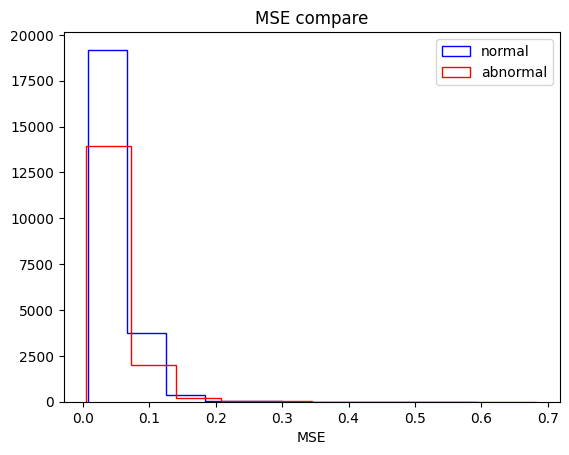

In [220]:
X_pred_train = model.predict(train_data)
scored_train = np.mean(np.abs(flatten(train_data) - flatten(X_pred_train)), axis=1)
X_pred_test = model.predict(test_data)
scored_test = np.mean(np.abs(flatten(test_data) - flatten(X_pred_test)), axis=1)

plt.title('MSE compare') 
plt.hist(scored_train, bins=10, color='blue', histtype='step', label='normal') 
plt.hist(scored_test, bins=10, color='red', histtype='step', label='abnormal') 
plt.xlabel('MSE')
plt.legend()
plt.show()

In [221]:
error_df['true_class'].value_counts()

true_class
0    9257
1    6976
Name: count, dtype: int64

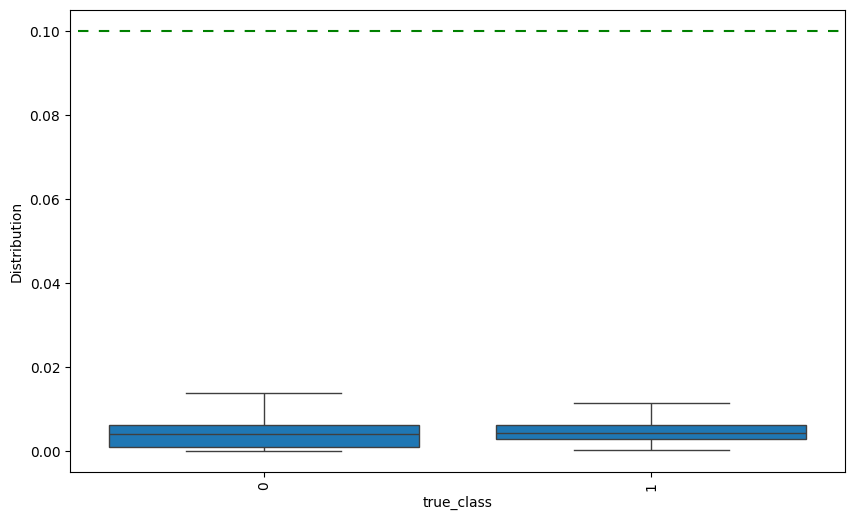

In [222]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='true_class', y='reconstruction_error', data=error_df, showfliers=False, saturation=1)
plt.ylabel('Distribution')

plt.axhline(y= 0.1, xmin=0.01, xmax=1,dashes=(5,5), c='g')

plt.xticks(rotation=90)
plt.show()

In [223]:
threshold = 0.01

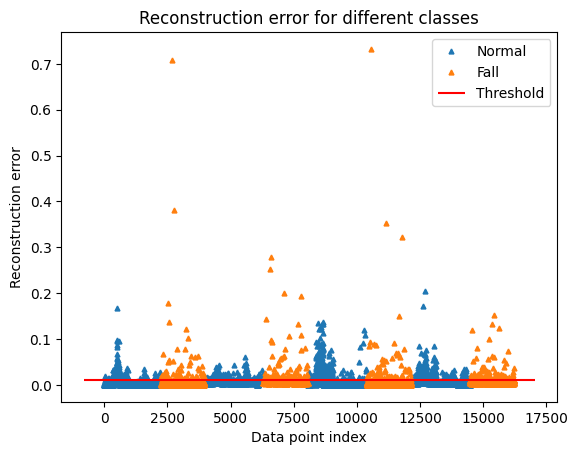

In [224]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='^', ms=3.5, linestyle='',
            label= "Normal" if name == 0 else "Fall")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

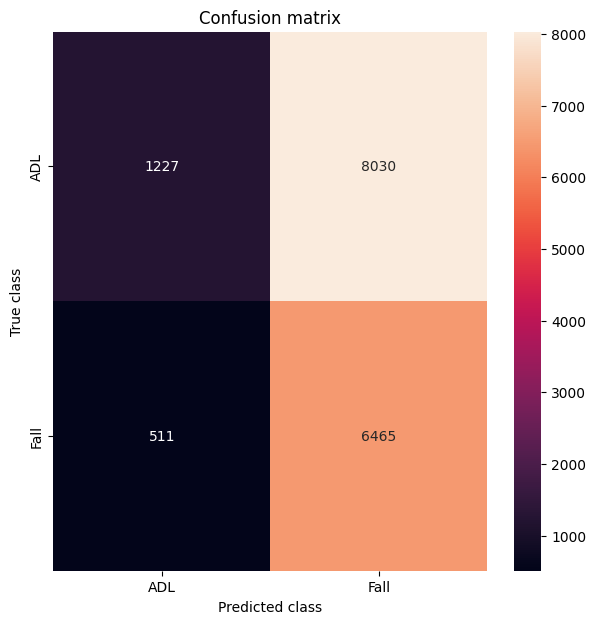

In [225]:
LABELS = ["ADL", "Fall"]

plt.figure(figsize=(7, 7))
y_pred = [0 if e > threshold else 1 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [226]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

precision, recall, f1,_ = precision_recall_fscore_support(test_labels,predictions,average='binary')
print ('Accuracy Score :',accuracy_score(error_df.true_class, predictions) )
print ('Precision :',precision )
print ('Recall :',recall )
print ('F1 :',f1 )

Accuracy Score : 0.5493131275796218
Precision : 0.4689667761956919
Recall : 0.3682626146788991
F1 : 0.41255821422836036
